## Processing COPC Data with PDAL, STAC, and Planetary Computer

This scenario demonstrates how to use the PDAL Python bindings to produce some simple raster products from a COPC file. 

### COPC

COPC is [Cloud Optimized Point Cloud](https://copc.io). COPC files are LASzip LAZ 1.4 data stored as a clustered octree. COPC files allow applications to select data for a window or a resolution, and allow them to limit how much data they must fetch, decompress, and process. You can read more about COPC at https://lidarmag.com/2021/12/27/cloud-native-geospatial-lidar-with-the-cloud-optimized-point-cloud/

### PDAL

PDAL supports reading and writing COPC with [readers.copc](https://pdal.io/stages/readers.copc.html) and [writers.copc](https://pdal.io/stages/writers.copc.html). 

### PDAL-Python

The [PDAL Python bindings](https://https://github.com/PDAL/python/) allow programmatic composition of [PDAL pipelines](https://https://pdal.io/pipeline.html). 

### What are we doing?

* Select some data from Chicago using Planetary Computer's STAC API
* Write a relative intensity image (RII) 
* Extract a HeightAboveGround surface and estimate the tallest point from the ground in the scene

### Setup

We have some imports and helper code to define first.

**Imports**

In [1]:
import pdal
import pystac_client
import planetary_computer
import PIL
import pyproj

**Useful code for estimating the UTM zone of a point**

Estimate the UTM zone of the point using [PyPROJ's method](https://gis.stackexchange.com/a/423614)

In [2]:
# Estimate our UTM zone
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info


def get_utm(point):
    longitude, latitude = point.x, point.y
    buffer = 0.001
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=longitude - buffer,
            south_lat_degree=latitude - buffer,
            east_lon_degree=longitude + buffer,
            north_lat_degree=latitude + buffer,
        ),
    )
    utm_crs = CRS.from_epsg(utm_crs_list[0].code)
    return utm_crs

### Figure out where to query

* Define a GeoJSON point geometry for [The Bean](https://en.wikipedia.org/wiki/Cloud_Gate)
* Buffer that in UTM by 400m
* Reproject it back to EPSG:4326 so we can use that to query the STAC API
* Plot it so it looks ok


In [3]:
# The Bean
bean = {"type": "Point", "coordinates": [-87.623358, 41.8826812]}

from shapely.geometry import shape
from shapely.ops import transform

geom = shape(bean)

utm = get_utm(geom)

wgs84 = pyproj.CRS("EPSG:4326")

project_dd_to_utm = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
project_utm_to_dd = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform

utm_point = transform(project_dd_to_utm, geom)
window = utm_point.buffer(400)

window_dd = transform(project_utm_to_dd, window)

import geopandas

df = geopandas.GeoDataFrame(geometry=[window_dd], crs="EPSG:4326")

df.explore()

### Query the Planetary Computer STAC API

* Query the STAC API for for the `3dep-lidar-copc` collection 
that intersects our buffered polygon centered on The Bean in Millenium Park
* Filter the responses to make sure 'Cook' is in the id, which is for Cook County, IL
* Sign the responses with Planetary Computer's tokens

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)

search = catalog.search(collections=["3dep-lidar-copc"], intersects=window_dd)
ic = search.get_all_items()

In [5]:
signed = planetary_computer.sign(ic)

**Define some variables we will use for querying**

In [6]:
OUTPUT_RESOLUTION = 2.0
READ_RESOLUTION = 2.0
polygon = window.wkt + f" / EPSG:{utm.to_epsg()}"

### Define a PDAL reader using [readers.copc](https://https://pdal.io/stages/readers.copc.html) for each tile

* `url` is a signed, HTTP-able URL we can read from
* `requests` is the number of threads to use. We need to use a much smaller number than the default `15`
* `resolution` is the floor'd resolution of the data. Resolution is not exact, and it depends up on the structure and breakpoints of the octree when the COPC file was built. Setting it to a value means the points that are returned at least meet that resolution
* `polygon` is a WKT or GeoJSON geometry that will act to both pre-filter the selection of the data from the COPC file *and* clip the data as they are read. 

In [20]:
readers = []
for tile in signed:
    url = tile.assets["data"].href
    reader = pdal.Reader.copc(
        url, requests=3, resolution=READ_RESOLUTION, polygon=polygon
    )
    readers.append(reader)

### Apply scaling to intensity

The LAS specification requires that Intensity and RGB values be in the 16-bit range, but we are going to be making some 8-bit PNGs. When we read data from PDAL, we want to divide the values by `256` to get them into 8-bit range. PDAL's [filters.assign](https://pdal.io/stages/filters.assign.html) filter can be used to manipulate the values of points as they are processed with expressions.

In [8]:
assign = pdal.Filter.assign(value=["Intensity = Intensity / 256"])

### Define the writer

[writers.gdal](https://https://pdal.io/stages/writers.gdal.html) is the workhorse writer for rasterizing point cloud data, and in this scenario, we are going to be using it write some TIFs.

* `resolution` defines the raster's resolution. This is independent of what we used to read the COPC file, but you typically want something that is or equal to the read resolution so you don't introduce artifacts in the output.
* `dimension` tells the writer point cloud dimension to read. The [dimensions](https://pdal.io/dimensions.html) available to the writer are determined by what is provided by the reader(s). 
* `output_type` tells the writer which band(s) to write in the data. See the writers.gdal documentation for more information on this
* `nodata` sets the value that represents the nodata value for the raster

In [9]:
writer = pdal.Writer.gdal(
    "intensity.tif",
    resolution=OUTPUT_RESOLUTION,
    dimension="Intensity",
    data_type="uint8",
    output_type="mean",
)

### Construct the pipelines

A pipeline is the PDAL entity that works with data. While they are usually defined by JSON (try printing `pipeline.pipeline`) and processed via the `pdal pipeline` command, they can also be constructed or composed programmatically via Python using the PDAL Python bindings. 

In [10]:
pipeline = None

# Gather up all of our readers and concatenate them together
for reader in readers:
    if not pipeline:
        pipeline = reader
    else:
        pipeline = pipeline | reader

pipeline = pipeline | assign | writer

### Execute the pipeline

Execute the pipeline so we can do something with the results. In our scenario, the results are going to be a TIF file that was written by writers.gdal. They might alternatively be Numpy arrays that we could inspect point values or filter or whatever.

In [11]:
%%time

# Use streaming mode at 1e6 points at a time. This
# helps us conserve memory for pipelines that are streamable
# check that with the pipeline.streamable property
results = pipeline.execute_streaming(chunk_size=1000000)
print(pipeline.log)

# the last stage of our pipeline is the writer, and the 'dimension'
# option on the writer is what we want to print
dimension = pipeline.stages[-1].options["dimension"]
print(f"Number of points returned for dimension {dimension}: {results}")


Number of points returned for dimension Intensity: 1047992
CPU times: user 21.7 s, sys: 576 ms, total: 22.3 s
Wall time: 21.6 s


### Display the relative intensity image

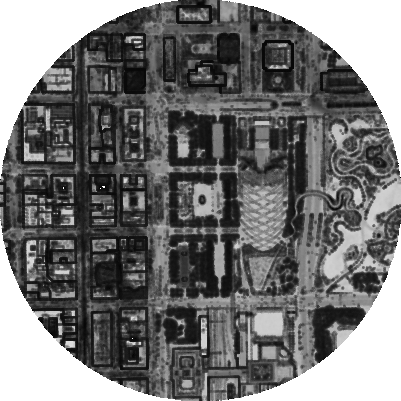

In [12]:
PIL.Image.open("intensity.tif")

### Compute a Height Above Ground surface model and determine the highest point



In [22]:
# Gather up all of our readers and concatenate them together
pipeline = None

# Gather up all of our readers and concatenate them together
for reader in readers:
    if not pipeline:
        pipeline = reader
    else:
        pipeline = pipeline | reader

merge = pdal.Filter.merge()
hag = pdal.Filter.hag_nn()
writer = pdal.Writer.gdal(
    "hag.tif",
    resolution=OUTPUT_RESOLUTION,
    dimension="HeightAboveGround",
    data_type="float32",
    output_type="mean",
)


pipeline = pipeline | merge | hag | writer

p = pipeline.execute()

### Color Ramp the PNG

In [23]:
colorramp = """-10.18599987030029297,247,251,255,255,-10.1860
-0.00115290172120908,228,239,249,255,-0.0012
0.17222511302108146,209,226,243,255,0.1722
0.6745767967615599,186,214,235,255,0.6746
1.70373090991130027,154,200,224,255,1.7037
3.80649503742675499,115,178,216,255,3.8065
6.60277122391136828,82,157,204,255,6.6028
13.59346169012289351,53,133,191,255,13.5935
35.1501281897475053,29,108,177,255,35.1501
68.49649969184777376,8,81,156,255,68.4965
347.23944590611102967,8,48,107,255,347.2394"""
with open("hag-colors.txt", "w") as f:
    f.write(colorramp)

In [24]:
%%bash
gdaldem color-relief hag.tif hag-colors.txt hag.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


### Display the HAG

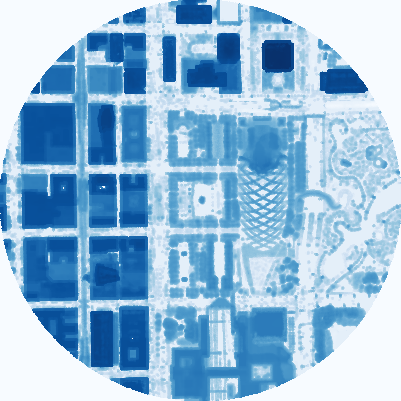

In [18]:
PIL.Image.open("hag.tif")

### Display statistics about the HAG points

In [19]:
import numpy

arr = pipeline.arrays[0]

print(arr)

# Note height is in meters
numpy.max(arr["HeightAboveGround"])

[(448433.62609864, 4637255.31905983, 372.27723393, 3390, 1, 1, 0, 0, 1, 15., 0, 0, 1.76456784e+08, 0, 0, 178.86)
 (448433.69609864, 4637255.22905983, 441.16723393,  491, 1, 1, 0, 0, 1, 15., 0, 0, 1.76456784e+08, 0, 0, 247.75)
 (448424.57609864, 4637255.18905983, 479.61723393,  673, 1, 1, 0, 0, 1, 15., 0, 0, 1.76456784e+08, 0, 0, 286.13)
 ...
 (448464.02609864, 4637236.15905983, 330.05723393,  283, 1, 1, 0, 0, 5, 15., 0, 0, 1.79808800e+08, 0, 0, 136.63)
 (448459.07609864, 4637253.67905983, 221.65723393, 1618, 1, 1, 0, 0, 5, 15., 0, 0, 1.79808800e+08, 0, 0,  28.23)
 (448464.63609864, 4637227.87905983, 197.45723393, 2836, 1, 1, 0, 0, 4, 15., 0, 0, 1.79808800e+08, 0, 0,   4.04)]


359.84000000000003